In [203]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch as to
import torch.nn as nn

# minor changes to plotting functions
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [204]:
# # Download all necessary files for the live tutorial
# # Post ODSC pull from GitHub Repo github.com/robert-alvarez

# data_url = 'https://www.dropbox.com/s/z0ilg0u8rsl2udz/pytorch_data.zip?dl=1'#This dl=1 means it automatically downloads

# if not os.path.exists('data'):
#     # Download the data zip file.
#     response = requests.get(data_url, stream=True)
#     zip_path = 'pytorch_data.zip'
#     with open(zip_path, 'wb') as f:
#         shutil.copyfileobj(response.raw, f)
#     # Unzip the file.
#     with zipfile.ZipFile(zip_path, 'r') as z:
#         z.extractall()
#     # Clean up.
#     os.remove(zip_path)

In [205]:
to.__version__

'1.0.1.post2'

# 1. Foundations

#### There are already values in an empty array, just some junk that is in memory.  For true zero tensors, use torch.zeros

In [206]:
e = to.empty(2,2)
e

tensor([[ 0.0000e+00,  1.5846e+29],
        [-4.9008e+08,  3.6902e+19]])

#### Use the following for constant tensors

In [207]:
z = to.zeros(2,2)
z

tensor([[0., 0.],
        [0., 0.]])

In [208]:
c = to.full((2,2),3)
c

tensor([[3., 3.],
        [3., 3.]])

#### Interoperating with numpy arrays is easy.

In [209]:
#From numpy to tensor
nump = to.tensor(np.linspace(0,3,5))
nump

tensor([0.0000, 0.7500, 1.5000, 2.2500, 3.0000], dtype=torch.float64)

In [210]:
#From tensor to numpy
nump.numpy()

array([0.  , 0.75, 1.5 , 2.25, 3.  ])

#### Explicit generation and operations

In [211]:
#Random Tensor Generator
t2 = to.rand(2,3,4, dtype = to.float64)
print("Complete Tensor \n {} \n".format(t2))
print("\n First matrix slice inside tensor \n{}\n".format(t2[0]))
print("{} is on the first matrix, second row, second column".format(t2[0,2,2]))

Complete Tensor 
 tensor([[[0.7975, 0.1147, 0.3570, 0.1854],
         [0.6443, 0.8720, 0.8226, 0.8399],
         [0.9932, 0.4153, 0.1095, 0.6735]],

        [[0.5344, 0.8598, 0.1228, 0.9163],
         [0.0655, 0.6755, 0.3106, 0.1184],
         [0.1231, 0.6790, 0.5424, 0.5196]]], dtype=torch.float64) 


 First matrix slice inside tensor 
tensor([[0.7975, 0.1147, 0.3570, 0.1854],
        [0.6443, 0.8720, 0.8226, 0.8399],
        [0.9932, 0.4153, 0.1095, 0.6735]], dtype=torch.float64)

0.10946000851869109 is on the first matrix, second row, second column


In [212]:
#Explicit tensor creation
t3 = to.tensor([[[1,2],[3,4]],[[5,6],[7,8]]] , dtype = to.int)

In [213]:
# this method creates a new tensor "y" that has the same properties (e.g. dtype) as the original tensor "x"
y = t3.new_ones(2,1) #
print(y)

tensor([[1],
        [1]], dtype=torch.int32)


In [214]:
t3 @ y #Cross Product of 

tensor([[[ 3],
         [ 7]],

        [[11],
         [15]]], dtype=torch.int32)

In [215]:
t3 * t3 # dot product

tensor([[[ 1,  4],
         [ 9, 16]],

        [[25, 36],
         [49, 64]]], dtype=torch.int32)

In [216]:
t3 @ t3 # cross product

tensor([[[  7,  10],
         [ 15,  22]],

        [[ 67,  78],
         [ 91, 106]]], dtype=torch.int32)

In [217]:
t3 + t3 #tensor addition

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [218]:
3 * t3 # scalar multiplication

tensor([[[ 3,  6],
         [ 9, 12]],

        [[15, 18],
         [21, 24]]], dtype=torch.int32)

In [219]:
#Get the index of the maximum value
t3.argmax()

tensor(7)

In [220]:
t3.add(t3) 

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [221]:
t3 

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]], dtype=torch.int32)

In [222]:
# The `*_` method works just like `inplace=True` in pandas
t3.add_(t3)

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [223]:
# We can reshape tensors as well though it's called "view" in pytorch
# support for 'reshape' has been added
x = to.randn(4,4)
y = x.view(16)
z = x.view(-1, 8)
w = x.reshape(2, -1)
print("x size = {},\ny size = {},\nz size = {},\nw size = {}".format(x.size(), y.size(), z.size(), w.size()))

x size = torch.Size([4, 4]),
y size = torch.Size([16]),
z size = torch.Size([2, 8]),
w size = torch.Size([2, 8])


In [224]:
#The x vector is flattened here
y

tensor([ 0.6775, -0.7481,  0.8390, -0.5937, -0.1808,  0.4913, -0.7070,  1.3637,
        -0.6204,  1.6601, -0.2970, -0.3536,  0.1085, -0.9917, -1.9407, -1.4992])

In [225]:
a = to.ones(5)
b = a.numpy()
a.add(to.from_numpy(b)) # Cannot simply add numpy arrays and torch tensors

tensor([2., 2., 2., 2., 2.])

# 1b. Autograd

<b>autograd</b> allows automatic differentiation for all operations on Tensors.

In [226]:
# Create a tensor and set requires_grade=True 
# to track computation with it
x = to.ones(2,2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [227]:
# Because y was created as a result of an operation, 
# it now has a grad_fn method
y = 3*x + 7
print(y)

tensor([[10., 10.],
        [10., 10.]], grad_fn=<AddBackward0>)


In [228]:
# We can do more stuff to y (and thus x) and calculate its derivatives
z = 2*y**2
w = z.mean()

print("z: {},\n\nw: {}".format(z, w))

z: tensor([[200., 200.],
        [200., 200.]], grad_fn=<MulBackward0>),

w: 200.0


In [229]:
#Computes the gradient of current tensor w.r.t. graph leaves.
w.backward()

In [230]:
x.grad

tensor([[30., 30.],
        [30., 30.]])

In [231]:
# Given the gradient, torch loops through the tensor operations, and then updates the values of the tensors

# 1c. Linear Regression With Stochastic Gradient Descent

The starting point for much of this notebook is based notes I transcribed from Dr. Alvarez's excellent ODSC presentation: "Understanding the PyTorch Framework with Applications to Deep Learning." 

#### A simple linear regression model in PyTorch

#### Step #1: Basic Definitions of Data Space

In [232]:
n_data = 10_000
X = to.ones(n_data,2) 

#populate random points into X
X[:,0].uniform_(-1.15,1.15)

actual = to.tensor([np.random.uniform(-14,14),
                    np.random.uniform(-14,14)])

y = X @ actual + to.randn(n_data)/3

#### Step #2: Train/Test Split

There is no autocovariance in this toy data dataset, therefore a simple train test split will suffice. 

In [233]:
#Train test split
train_size = int(n_data * .75)
test_size = n_data - train_size

X_train, X_test = X[0 : train_size, :], X[train_size : n_data, :]
y_train, y_test = y[0 : train_size],    y[train_size : n_data]

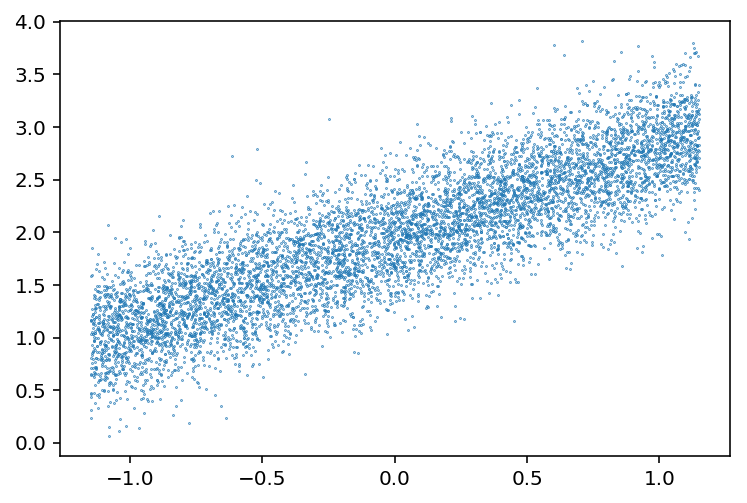

In [234]:
plt.scatter(X_train[:,0], y_train, s = .1);

#### Step #3: Define Scoring Function

In [235]:
def mean_standard_error(y, y_pred):
    return ((y - y_pred) ** 2).mean()

#### Step #4: Start with a arbitrary model to begin training 

In [236]:
#A random prediction
model = to.tensor([np.random.uniform(-14,14),
                   np.random.uniform(-14,14)])

y_hat = X_train @ model
mean_standard_error(y_hat, y_train)

tensor(48.3855)

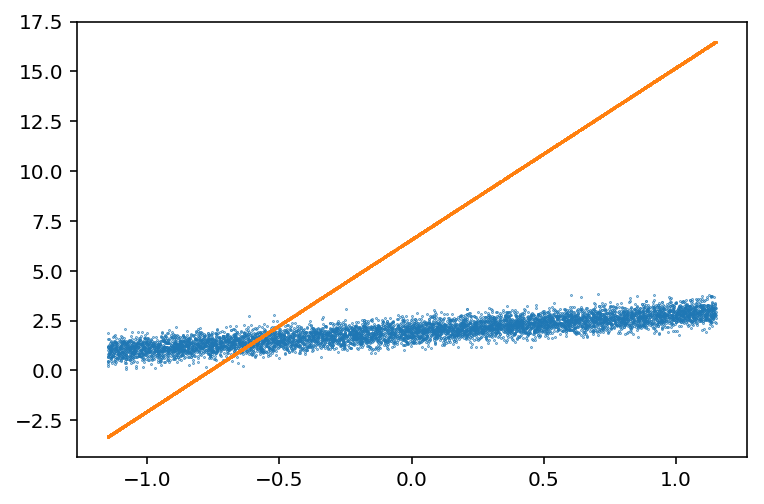

In [237]:
plt.scatter(X_train[:,0],y_train, s = .1)
plt.scatter(X_train[:,0],y_hat, s = .1);

#### Step #5: Parameterize the model

In [238]:
model = nn.Parameter(model)
model

Parameter containing:
tensor([8.6251, 6.5764], requires_grad=True)

#### Bringing Step 1-5 together 

step:    5 MSE: 4.660867691040039
step:   10 MSE: 1.740560531616211
step:   15 MSE: 0.6774241924285889
step:   20 MSE: 0.266770601272583
step:   25 MSE: 0.10539531707763672
step:   30 MSE: 0.041676104068756104
step:   35 MSE: 0.016483798623085022
step:   40 MSE: 0.006520077586174011
step:   45 MSE: 0.002579040825366974
step:   50 MSE: 0.0010201409459114075
step:   55 MSE: 0.0004035383462905884
step:   60 MSE: 0.0001596212387084961
step:   65 MSE: 6.314367055892944e-05
step:   70 MSE: 2.4974346160888672e-05
step:   75 MSE: 9.864568710327148e-06
step:   80 MSE: 3.91155481338501e-06
step:   85 MSE: 1.5497207641601562e-06
step:   90 MSE: 6.258487701416016e-07
step:   95 MSE: 2.1606683731079102e-07
step:  100 MSE: 7.450580596923828e-08
step:  105 MSE: 1.4901161193847656e-08
step:  110 MSE: 2.9802322387695312e-08

convergence of stochastic gradient descent at step 111


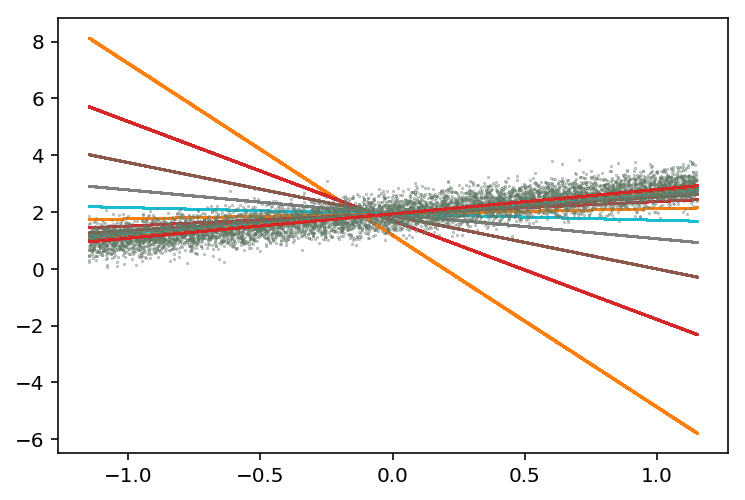

In [239]:
#A glorified stochastic gradient descent machine
def gentle_linear_torch(data, target, learning_rate, iterations):
    answer = {}
    def mean_standard_error(y_actual, y_pred):
        return ((y_actual - y_pred) ** 2).mean()
    
    #Random Initial Model
    model = nn.Parameter(to.tensor([np.random.uniform(-14,14),
                                    np.random.uniform(-14,14)]))

    y_hat = data @ model
    mean_standard_error(y_hat, target)

    for time in range(iterations):
        y_hat = data @ model
        loss = mean_standard_error(target, y_hat)
        
        if time > 0 and last_loss == loss:
            print("\nconvergence of stochastic gradient descent at step {}".format(time))
            return(model)
            break
        
        if time > 0 and time % 5 == 0:
            print("step: {:4} MSE: {:5}".format(time, float(last_loss.data - loss.data)))
            plt.scatter(data[:,0], target, s = .1, alpha = .05);
            plt.scatter(data[:,0], y_hat.detach().numpy(), s = .1);
        
        loss.backward()
        with to.no_grad():
            #These *_ set values like inplace = True
            model.sub_(learning_rate * model.grad) 
            model.grad.zero_()
        
        last_loss = loss
    
    print("\nmodel did not converge in max_iterations")
    return(model)

sgd = gentle_linear_torch( X_train, y_train, .1, 1000)

In [240]:
y_hat =  X_test @ sgd
float(mean_standard_error(y_hat, y_test))

0.10991530865430832

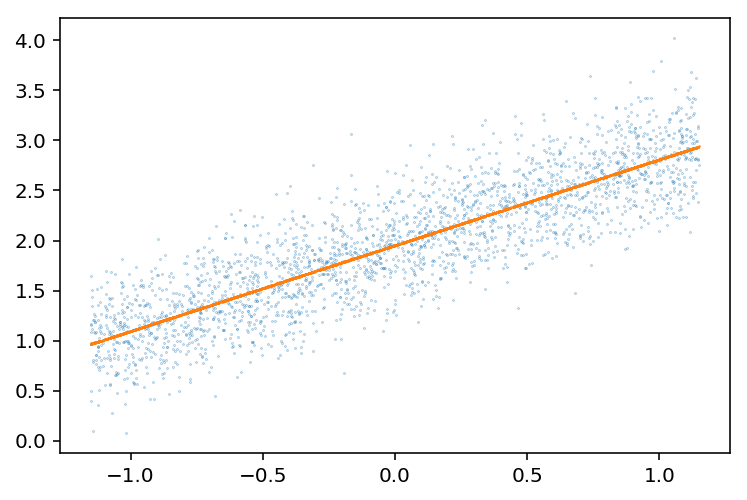

In [241]:
plt.scatter(X_test[:,0], y_test, s = .1, alpha = .5);
plt.scatter(X_test[:,0], y_hat.detach().numpy(), s = .1);

# 1d. Normal Equation Solution

Calculaing the linear regression with Ordinary least squares (OLS) estimator: <br><br>
$\hat{\boldsymbol{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}$

In [242]:
theta = (to.t(X_train) @ X_train).inverse() @ to.t(X_train) @ y_train
print(theta)
print(sgd)

tensor([0.8584, 1.9531])
Parameter containing:
tensor([0.8580, 1.9532], requires_grad=True)


# 1e. GPU and CPU management

In [243]:
#Following Code heavily borrorwed from Will Ballard's work PyTorch Deep Learning in 7 Days 

cpu = to.device("cpu")
# This will spit back an ugly error on my macbook
# gpu = to.device("cuda")

In [244]:
y = to.tensor([2.5], device = cpu)

In [245]:
# Remember to not mix devices on the calls. Fix problems with 
# x.to(cpu) + y.to(cpu)

# 2 Datasets

In [246]:
class IrisDataset(Dataset):
    #This class is a logical extension of pandas
    def __init__(self):
        self.data = pd.read_csv("./Iris.csv")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        return self.data.iloc[index]

In [247]:
iris = IrisDataset()
len(iris), iris[0]

(150, Id                         1
 SepalLengthCm            5.1
 SepalWidthCm             3.5
 PetalLengthCm            1.4
 PetalWidthCm             0.2
 Species          Iris-setosa
 Name: 0, dtype: object)

#### This almost works, but we have a named tuple, but we need a tensor for columns. 

In [248]:
class TensorIrisDataset(IrisDataset):
    def __getitem__(self, index):
        item = super().__getitem__(index)
        
        return {
            'tensor': to.Tensor([item.SepalLengthCm,
                                item.SepalWidthCm,
                                item.PetalLengthCm,
                                item.PetalWidthCm]),
            'label': item.Species}

# and output...
iris_tensors = TensorIrisDataset()
len(iris_tensors), tensors[0]

(150,
 {'tensor': tensor([5.1000, 3.5000, 1.4000, 0.2000]), 'label': 'Iris-setosa'})

#### We feed our neural nets in batches and Pytorch has a handy iteratable loader

In [249]:
from torch.utils.data import DataLoader

In [250]:
loader = DataLoader(iris_tensors, batch_size = 16, shuffle = True, num_workers = 4)

for batch in loader:
    print(batch)

{'tensor': tensor([[5.1000, 3.8000, 1.9000, 0.4000],
        [5.2000, 2.7000, 3.9000, 1.4000],
        [6.1000, 2.8000, 4.7000, 1.2000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [5.2000, 3.4000, 1.4000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.0000, 3.5000, 1.3000, 0.3000],
        [5.8000, 2.6000, 4.0000, 1.2000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [5.6000, 2.8000, 4.9000, 2.0000],
        [6.4000, 2.9000, 4.3000, 1.3000],
        [4.8000, 3.4000, 1.9000, 0.2000],
        [5.0000, 2.3000, 3.3000, 1.0000],
        [5.1000, 3.5000, 1.4000, 0.3000]]), 'label': ['Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-virginica', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa']}
{'tensor': tensor([[6.7000, 3.3000, 5.

# 2b. Torchvision

In [251]:
import torchvision

In [252]:
dir(torchvision.datasets)[0:24]

['CIFAR10',
 'CIFAR100',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'DatasetFolder',
 'EMNIST',
 'FakeData',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'ImageFolder',
 'KMNIST',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Omniglot',
 'PhotoTour',
 'SBU',
 'SEMEION',
 'STL10',
 'SVHN',
 'VOCDetection',
 'VOCSegmentation']

In [265]:
fmnist = torchvision.datasets.FashionMNIST("./var", download = True)

Files already downloaded and verified


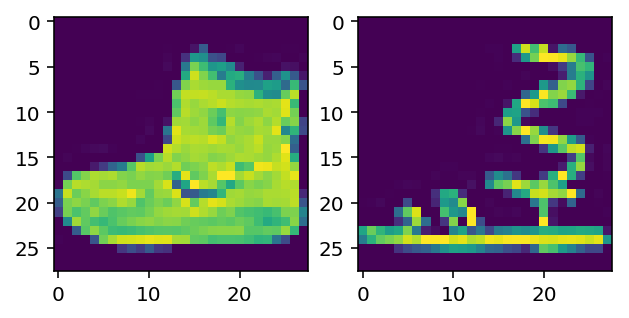

In [281]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5));

ax[0].imshow(fmnist[0][0]);
ax[1].imshow(fmnist[10250][0]);

In [255]:
from torchvision import transforms

pipe = transforms.Compose([transforms.ToTensor()])

fmnist_transformed = torchvision.datasets.FashionMNIST('./var', transform = pipe)

In [256]:
#This is the tensor of the Shoe above
fmnist_transformed[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

#### Calculate the mean and standard deviation of pixels in dataset

In [257]:
images = to.cat([
    image for image, label in fmnist_transformed])

print("shape: {}, mean: {}, std: {}".format(images.shape, images.mean(), images.std()))

shape: torch.Size([60000, 28, 28]), mean: 0.28590065240859985, std: 0.3530242443084717




26427392it [00:24, 3256389.80it/s]                              

# 3. Basic Neural Net

In [258]:
import networkx as nx
import math

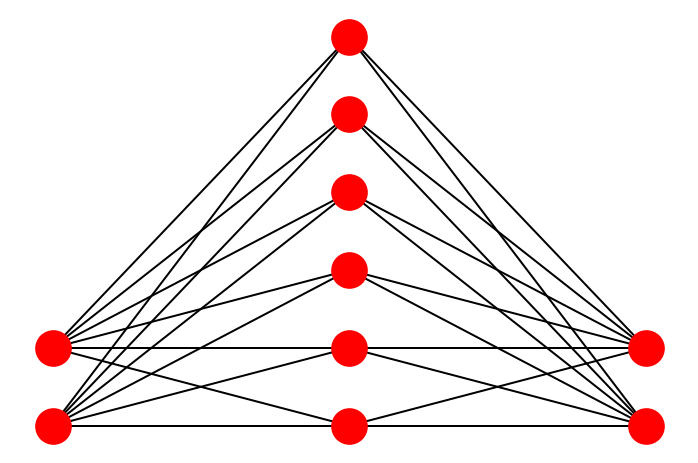

In [259]:
dense_graph = nx.Graph()
inputs = {i: (0, i) for i in range(0, 2)}
activations = {i+100: (1, i) for i in range(0, 6)}
outputs= {i+1000: (2, i) for i in range(0, 2)}
data_dictionary = {**inputs, **activations, **outputs}

#Populate the nodes with edges
for i in inputs:
    for activation in activations:
        dense_graph.add_edge(i, activation)

for activation in activations:
    for output in outputs:
        dense_graph.add_edge(activation, output)

nx.draw_networkx_nodes(dense_graph,
                       data_dictionary,
                       nodelist= data_dictionary.keys(), node_color = "red")

nx.draw_networkx_edges(dense_graph, data_dictionary, edge_color= "black")
axes = plt.axis("off")

# 3a. Canonical Build with random inputs and outputs

In [260]:
inputs = to.rand(1,1,64,64)
outputs = to.rand(1,2)

In [261]:
outputs

tensor([[0.1081, 0.1630]])

#### Die Roller Function

In [262]:
def dice_roller(rolls):
    table = {}
    for i in range(rolls):
        number_of_dice = np.random.randint(1,7)
        dice = {1:20, 2:12, 3:10, 4:8, 5:6, 6:4}
        bag = np.random.randint(1, dice[number_of_dice], number_of_dice)
        bag = [x + np.random.uniform(-1,1) for x in bag]
        table[i] = {"first_roll": bag[0], "sum": sum(bag), "target": number_of_dice}
    
    return(table)

#### Data Generaion

In [263]:
df = pd.DataFrame(dice_roller(20_000)).T
df[df.target == 3].describe()

,first_roll,sum,target
count,3394.000000,3394.000000,3394.0
mean,5.060085,14.895392,3.0
std,2.613919,4.573561,0.0
min,0.000607,0.571350,3.0
25%,2.816544,11.632505,3.0
50%,5.141434,14.938396,3.0
75%,7.262169,18.037047,3.0
max,9.984835,28.263055,3.0


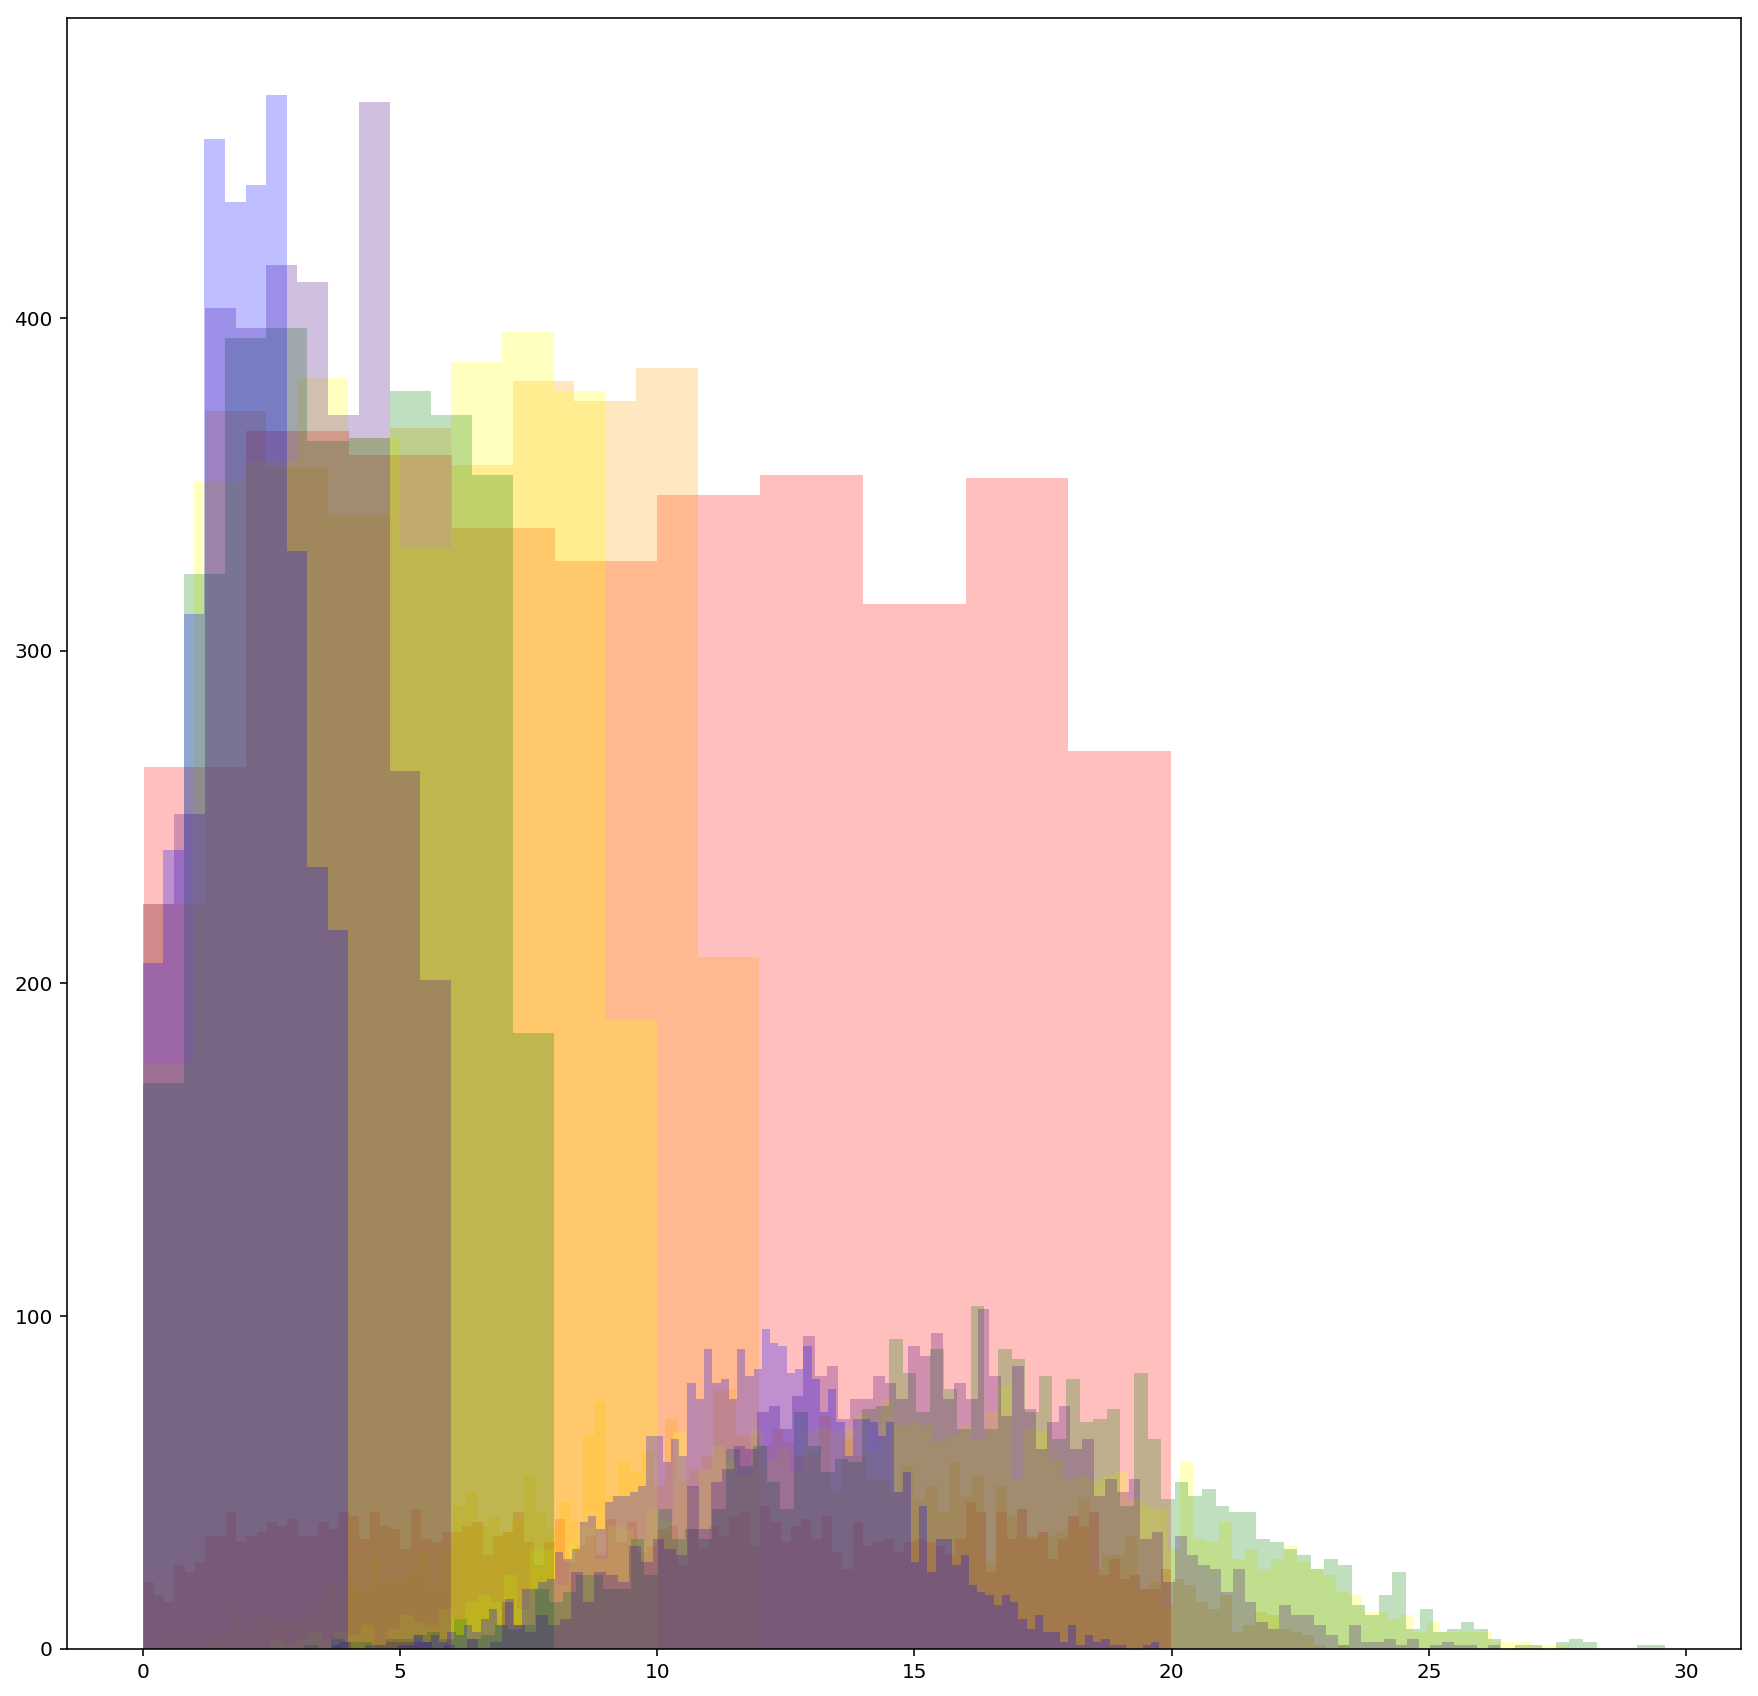

In [179]:
figure, ax = plt.subplots(figsize=(15, 15))

color = ["","red", "orange", "yellow", "green", "indigo", "blue"]

for i in range(1,7):  
    ax = plt.hist(df[df.target == i]["sum"], bins = 100, alpha = .25, color = color[i])
    ax = plt.hist(df[df.target == i]["first_roll"], bins = 10, alpha = .25, color = color[i])


#### Train test split

In [186]:
from sklearn.preprocessing import StandardScaler
#Train test split

X = df[["first_roll", "sum"]]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25)

# ss = StandardScaler()

# X_train_sc = ss.fit_transform(X_train)
# X_test_sc  = ss.transform(X_test)

X_train_to, X_test_to = to.tensor(X_train.values), to.tensor(X_test.values)
y_train_to, y_test_to = to.tensor(y_train.values), to.tensor(y_test.values)


In [189]:
X_train_to

tensor([[ 3.3323, 18.0679],
        [ 3.0167, 11.4310],
        [ 2.0024, 14.8693],
        ...,
        [ 4.0561,  4.0561],
        [ 2.5678, 12.1175],
        [ 3.7685, 12.8915]], dtype=torch.float64)

#### Build Model

In [192]:
model = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),            
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 6))

optimizer = to.optim.Adam(model.parameters())
criterion = nn.MSELoss()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=6, bias=True)
)


In [282]:
585 + 544 + 426 + 497

2052

In [ ]:
model = nn.Sequential(
        nn.Linear(2, 1, bias=False))

optimizer = to.optim.Adam(model.parameters())
criterion = nn.MSELoss()

total_loss = []
num_samples = 10_000

for num in range(num_samples):
    # Progress bar indicator
    if num % (num_samples//5) == 0:
        print('{0}: %: {1:.3f}'.format(num,num/num_samples * 100))
        
    # data prep
    x = 4*to.rand(2) #generate two random numbers uniformly on (0,4)
    data, target = Variable(x), Variable(x[0] + x[1])
    
    # Feed forward through NN
    output = model(data)
    loss = criterion(output, target)
    total_loss.append(loss)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
fig,ax=plt.subplots(figsize=(11,8))
ax.plot(total_loss,marker='.',ls='',markersize=1.)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');